In [77]:
import torch.nn.functional as F
import torch
import torchvision
from matplotlib import pyplot as plt
from torchvision import utils
import numpy as np
import torch.nn as nn
import os
import pandas as pd
import PIL
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter("runs/Solo testo")

myseed = 0
torch.manual_seed(myseed)
np.random.seed(myseed)
generator=torch.Generator()
generator.manual_seed(myseed)

%matplotlib inline

In [78]:
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(dev)

cuda


In [79]:
data_path = "./"

In [80]:
images = os.listdir(f"{data_path}DATASET")
print(images)

['P_2_62.png', 'P_232.png', 'P_720.png', 'P_3_416.png', 'P_2_67.png', 'P_2_9.png', 'P_98.png', 'P_759.png', 'P_667.png', 'P_2_19.png', 'P_3_463.png', 'P_3_274.png', 'P_795.png', 'P_619.png', 'P_289.png', 'P_3_306.png', 'P_493.png', 'P_486.png', 'P_1_154.png', 'P_3_5.png', 'P_2_88.png', 'P_3_204.png', 'P_412.png', 'P_1_112.png', 'P_3_273.png', 'P_460.png', 'P_130.png', 'P_654.png', 'P_405.png', 'P_3_290.png', 'P_3_396.png', 'P_3_180.png', 'P_3_115.png', 'P_3_17.png', 'P_45.png', 'P_782.png', 'P_827.png', 'P_1_107.png', 'P_753.png', 'P_786.png', 'P_507.png', 'P_3_103.png', 'P_719.png', 'P_497.png', 'P_310.png', 'P_743.png', 'P_446.png', 'P_3_342.png', 'P_3_421.png', 'P_13.png', 'P_382.png', 'P_1_8.png', 'P_2_93.png', 'P_3_410.png', 'P_442.png', 'P_2_70.png', 'P_559.png', 'P_19.png', 'P_245.png', 'P_2.png', 'P_42.png', 'P_3_500.png', 'P_3_409.png', 'P_3_203.png', 'P_3_297.png', 'P_1_143.png', 'P_3_21.png', 'P_328.png', 'P_3_359.png', 'P_3_83.png', 'P_2_27.png', 'P_2_102.png', 'P_3_134.png

In [81]:
len(images)

1589

In [82]:
df = pd.read_excel("trainANDtest.xls")

In [83]:
del df["Row_number"]
del df["Unnamed: 0"]

In [84]:
df

,ImageFile,Hospital,Age,Sex,PositivityAtAdmission,Temp_C,DaysFever,Cough,DifficultyInBreathing,WBC,...,pH,HighBloodPressure,Diabetes,Dementia,BPCO,Cancer,ChronicKidneyDisease,RespiratoryFailure,Prognosis,Death
0,P_102.png,1,72,1,1,37.3,3,1,0,5.37,...,7.46,0,0,0,0,1,0,0,1,0
1,P_131.png,4,35,0,1,39.3,3,1,0,5.76,...,7.46,1,0,0,0,0,0,0,0,0
2,P_132.png,4,57,0,1,37.0,3,0,0,11.48,...,7.42,0,0,0,0,0,0,0,0,0
3,P_117.png,1,39,1,1,37.2,2,1,0,10.17,...,7.38,0,0,0,0,0,0,0,0,0
4,P_16.png,1,44,0,1,38.0,3,1,0,6.64,...,7.47,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1584,P_3_432.png,6,84,1,1,37.0,2,0,0,7.20,...,7.46,1,0,1,0,0,0,0,0,0
1585,P_3_105.png,6,51,0,1,38.0,3,0,1,6.40,...,7.44,0,1,0,0,0,0,0,1,0
1586,P_3_233.png,6,70,1,1,36.4,2,1,0,6.00,...,7.50,1,0,0,0,0,0,0,0,0
1587,P_3_414.png,6,90,0,1,36.2,4,0,0,7.10,...,7.42,0,1,0,0,0,0,0,0,0


In [134]:
class TextDataset(Dataset):
    """Tabular and Image dataset."""

    def __init__(self, indices, image_dir, transform=None):
        self.image_dir = image_dir
        self.indices = indices
        #self.tabular = self.tabular[self.tabular["Hospital"]=="A"]
        self.transform = transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        tabular = self.indices.iloc[idx, 0:]

        y = tabular["Prognosis"]

        #image = PIL.Image.open(f"{self.image_dir}/{tabular['ImageFile']}")
        #image = image.convert('L')
        #image = np.array(image)
        #image = image[..., :3]

        #image = transforms.functional.to_tensor(image)

        tabular = tabular[['Age', 'Sex', 'PositivityAtAdmission',
       'Temp_C', 'DaysFever', 'Cough', 'DifficultyInBreathing', 'WBC', 'RBC',
       'CRP', 'Glucose', 'LDH', 'INR', 'PaO2', 'PaCO2', 'pH',
       'HighBloodPressure', 'Diabetes', 'Dementia', 'BPCO', 'Cancer',
       'ChronicKidneyDisease', 'RespiratoryFailure']]
        tabular = tabular.tolist()
        tabular = torch.FloatTensor(tabular)
        
        #if self.transform:
            #image = self.transform(image)

        return tabular, y
    
from torchvision import transforms as T
my_transform = T.Compose([T.Resize((256,256)),
                          T.RandomApply(
                            [T.RandomHorizontalFlip(),
                             T.RandomCrop(256, padding=4)],
                            p=.5
                          )])

In [135]:
from sklearn.model_selection import train_test_split

tv_idx, test_idx = train_test_split(np.arange(len(df["Prognosis"])), test_size=0.2, shuffle=True, stratify=df["Prognosis"])


In [136]:
train_val_df = df.iloc[tv_idx]
train_val = TextDataset(indices=train_val_df, image_dir=f"{data_path}DATASET", transform=my_transform)

In [137]:
len(train_val)

1271

In [138]:
test_df = df.iloc[test_idx]
test_set = TextDataset(indices=test_df, image_dir=f"{data_path}DATASET", transform=my_transform)

In [139]:
len(test_set)

318

In [145]:
i = 3
print(f"{train_val[i][0].size()}, label = {train_val[i][1]}")

torch.Size([23]), label = 1


In [146]:
dev = torch.device('cuda')
print(dev)

cuda


# 2. SOLO TESTO

In [147]:
class TextNN(nn.Module):

    #Constructor
    def __init__(self):
    # Call parent contructor
        super().__init__()
        torch.manual_seed(myseed)
        self.relu = nn.ReLU()
        self.ln1 = nn.Linear(23, 50) #23 sono le colonne in input
        self.ln2 = nn.Linear(50, 50)
        self.ln3 = nn.Linear(50, 10)
        self.ln4 = nn.Linear(10, 1)
    
    def forward(self, tab):
        tab = self.ln1(tab)
        tab = self.relu(tab)
        tab = self.ln2(tab)
        tab = self.relu(tab)
        tab = self.ln3(tab)
        tab = self.relu(tab)
        tab = self.ln4(tab)

        return tab

model = TextNN()
print(model)

TextNN(
  (relu): ReLU()
  (ln1): Linear(in_features=23, out_features=50, bias=True)
  (ln2): Linear(in_features=50, out_features=50, bias=True)
  (ln3): Linear(in_features=50, out_features=10, bias=True)
  (ln4): Linear(in_features=10, out_features=1, bias=True)
)


In [148]:
# Define an optimizier
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr = 0.0001)
# Define a loss 
criterion = nn.BCEWithLogitsLoss()
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr = 0.01, epochs=5, steps_per_epoch=350)

In [149]:
def train(net, loaders, optimizer, criterion, epochs=500, dev=dev, save_param = False, model_name="only-text"):
    torch.manual_seed(myseed)
    try:
        net = net.to(dev)
        #print(net)
        # Initialize history
        history_loss = {"train": [], "val": [], "test": []}
        history_accuracy = {"train": [], "val": [], "test": []}
        # Store the best val accuracy
        best_val_accuracy = 0

        # Process each epoch
        for epoch in range(epochs):
            # Initialize epoch variables
            sum_loss = {"train": 0, "val": 0, "test": 0}
            sum_accuracy = {"train": 0, "val": 0, "test": 0}
            # Process each split
            for split in ["train", "val", "test"]:
                if split == "train":
                  net.train()
                else:
                  net.eval()
                # Process each batch
                for (tabular, labels) in loaders[split]:
                    # Move to CUDA
                    tabular = tabular.to(dev)
                    labels = labels.to(dev)
                    # Reset gradients
                    optimizer.zero_grad()
                    # Compute output
                    pred = net(tabular)
                    #pred = pred.squeeze(dim=1) # Output shape is [Batch size, 1], but we want [Batch size]
                    labels = labels.unsqueeze(1)
                    labels = labels.float()
                    loss = criterion(pred, labels)
                    # Update loss
                    sum_loss[split] += loss.item()
                    # Check parameter update
                    if split == "train":
                        # Compute gradients
                        loss.backward()
                        # Optimize
                        optimizer.step()
                    # Compute accuracy
                    #pred_labels = pred.argmax(1) + 1
                    pred_labels = (pred >= 0).long() # Binarize predictions to 0 and 1
                    batch_accuracy = (pred_labels == labels).sum().item()/tabular.size(0)
                    # Update accuracy
                    sum_accuracy[split] += batch_accuracy
                scheduler.step()
            # Compute epoch loss/accuracy
            epoch_loss = {split: sum_loss[split]/len(loaders[split]) for split in ["train", "val", "test"]}
            epoch_accuracy = {split: sum_accuracy[split]/len(loaders[split]) for split in ["train", "val", "test"]}

            # Store params at the best validation accuracy
            if save_param and epoch_accuracy["val"] > best_val_accuracy:
              #torch.save(net.state_dict(), f"{net.__class__.__name__}_best_val.pth")
              torch.save(net.state_dict(), f"{model_name}_best_val.pth")
              best_val_accuracy = epoch_accuracy["val"]

            # Update history
            for split in ["train", "val", "test"]:
                history_loss[split].append(epoch_loss[split])
                history_accuracy[split].append(epoch_accuracy[split])
                
            writer.add_scalar("Train Loss", epoch_loss['train'], epoch)
            writer.add_scalar("Valid Loss", epoch_loss['val'], epoch)
            writer.add_scalar("Test Loss", epoch_loss['test'], epoch)
            writer.add_scalar("Train Accuracy", epoch_accuracy['train'], epoch)
            writer.add_scalar("Valid Accuracy", epoch_accuracy['val'], epoch)
            writer.add_scalar("Test Accuracy", epoch_accuracy['test'], epoch)
            
            # Print info
            print(f"Epoch {epoch+1}:",
                  f"TrL={epoch_loss['train']:.4f},",
                  f"TrA={epoch_accuracy['train']:.4f},",
                  f"VL={epoch_loss['val']:.4f},",
                  f"VA={epoch_accuracy['val']:.4f},",
                  f"TeL={epoch_loss['test']:.4f},",
                  f"TeA={epoch_accuracy['test']:.4f},",
                  f"LR={optimizer.param_groups[0]['lr']:.5f},")
    except KeyboardInterrupt:
        print("Interrupted")
    finally:
        # Plot loss
        plt.title("Loss")
        for split in ["train", "val", "test"]:
            plt.plot(history_loss[split], label=split)
        plt.legend()
        plt.show()
        # Plot accuracy
        plt.title("Accuracy")
        for split in ["train", "val", "test"]:
            plt.plot(history_accuracy[split], label=split)
        plt.legend()
        plt.show()

In [150]:
def reset_weights(m):

    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()

In [151]:
test_loader  = DataLoader(test_set,  batch_size=8, num_workers=2, drop_last=False, shuffle=False, generator=generator)

In [155]:
tv_labels = train_val_df['Prognosis'].tolist()

------------fold no---------0----------------------
Total samples in hospital A: 99
Total samples in hospital B: 76
Total samples in hospital C: 120
Total samples in hospital D: 115
Total samples in hospital E: 66
Total samples in hospital F: 540


/home/lmancuso/anaconda3/envs/openfl/lib/python3.8/site-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Epoch 1: TrL=0.6458, TrA=0.6496, VL=0.5892, VA=0.6847, TeL=0.5674, TeA=0.7010, LR=0.00040,
Epoch 2: TrL=0.6090, TrA=0.6732, VL=0.5556, VA=0.6936, TeL=0.5378, TeA=0.7365, LR=0.00040,
Epoch 3: TrL=0.5730, TrA=0.7116, VL=0.5847, VA=0.6808, TeL=0.5424, TeA=0.7146, LR=0.00041,
Epoch 4: TrL=0.5706, TrA=0.7146, VL=0.5575, VA=0.6931, TeL=0.5211, TeA=0.7427, LR=0.00041,
Epoch 5: TrL=0.5538, TrA=0.7274, VL=0.5844, VA=0.6730, TeL=0.5313, TeA=0.7240, LR=0.00042,
Epoch 6: TrL=0.5571, TrA=0.7234, VL=0.5474, VA=0.6853, TeL=0.5075, TeA=0.7365, LR=0.00043,
Epoch 7: TrL=0.5547, TrA=0.7175, VL=0.6590, VA=0.6456, TeL=0.5764, TeA=0.6833, LR=0.00044,
Epoch 8: TrL=0.5486, TrA=0.7224, VL=0.5409, VA=0.7137, TeL=0.5042, TeA=0.7365, LR=0.00045,
Epoch 9: TrL=0.5364, TrA=0.7461, VL=0.5528, VA=0.6892, TeL=0.4968, TeA=0.7438, LR=0.00046,
Epoch 10: TrL=0.5236, TrA=0.7382, VL=0.5448, VA=0.7048, TeL=0.4959, TeA=0.7562, LR=0.00048,
Epoch 11: TrL=0.5444, TrA=0.7185, VL=0.5914, VA=0.6892, TeL=0.5147, TeA=0.7531, LR=0.0004

Epoch 91: TrL=0.5161, TrA=0.7402, VL=0.5137, VA=0.6775, TeL=0.4511, TeA=0.7396, LR=0.00552,
Epoch 92: TrL=0.5285, TrA=0.7461, VL=0.6941, VA=0.7243, TeL=0.5187, TeA=0.7594, LR=0.00560,
Epoch 93: TrL=0.5005, TrA=0.7470, VL=0.5509, VA=0.6735, TeL=0.5200, TeA=0.7198, LR=0.00569,
Epoch 94: TrL=0.5171, TrA=0.7402, VL=0.5949, VA=0.7087, TeL=0.4883, TeA=0.7688, LR=0.00577,
Epoch 95: TrL=0.5071, TrA=0.7441, VL=0.7161, VA=0.7048, TeL=0.4932, TeA=0.7719, LR=0.00586,
Epoch 96: TrL=0.5035, TrA=0.7530, VL=0.5724, VA=0.6618, TeL=0.4755, TeA=0.7552, LR=0.00595,
Epoch 97: TrL=0.5183, TrA=0.7470, VL=0.5617, VA=0.7042, TeL=0.4631, TeA=0.7531, LR=0.00603,
Epoch 98: TrL=0.5051, TrA=0.7598, VL=0.5931, VA=0.7048, TeL=0.4535, TeA=0.7781, LR=0.00612,
Epoch 99: TrL=0.4977, TrA=0.7530, VL=0.6728, VA=0.7087, TeL=0.5188, TeA=0.7469, LR=0.00620,
Epoch 100: TrL=0.5226, TrA=0.7333, VL=0.5414, VA=0.7171, TeL=0.4854, TeA=0.7479, LR=0.00628,
Epoch 101: TrL=0.5116, TrA=0.7451, VL=0.5432, VA=0.6970, TeL=0.4699, TeA=0.7562

Epoch 180: TrL=0.5039, TrA=0.7480, VL=0.5511, VA=0.7321, TeL=0.4618, TeA=0.7771, LR=0.01000,
Epoch 181: TrL=0.5015, TrA=0.7736, VL=0.5260, VA=0.7003, TeL=0.4991, TeA=0.7490, LR=0.00999,
Epoch 182: TrL=0.4952, TrA=0.7608, VL=0.5833, VA=0.7126, TeL=0.4749, TeA=0.7688, LR=0.00999,
Epoch 183: TrL=0.4935, TrA=0.7530, VL=0.5415, VA=0.7439, TeL=0.4800, TeA=0.7719, LR=0.00999,
Epoch 184: TrL=0.4904, TrA=0.7589, VL=0.5435, VA=0.7204, TeL=0.4595, TeA=0.7771, LR=0.00999,
Epoch 185: TrL=0.5000, TrA=0.7520, VL=0.5418, VA=0.7243, TeL=0.4555, TeA=0.7583, LR=0.00998,
Epoch 186: TrL=0.5242, TrA=0.7402, VL=0.5295, VA=0.7087, TeL=0.4611, TeA=0.7719, LR=0.00998,
Epoch 187: TrL=0.4970, TrA=0.7520, VL=0.5117, VA=0.7243, TeL=0.4491, TeA=0.7875, LR=0.00998,
Epoch 188: TrL=0.4920, TrA=0.7677, VL=0.5188, VA=0.7204, TeL=0.5176, TeA=0.7448, LR=0.00997,
Epoch 189: TrL=0.5010, TrA=0.7549, VL=0.5565, VA=0.7087, TeL=0.4920, TeA=0.7448, LR=0.00997,
Epoch 190: TrL=0.5044, TrA=0.7648, VL=0.5150, VA=0.7165, TeL=0.4777, T

Epoch 269: TrL=0.5109, TrA=0.7500, VL=0.5477, VA=0.7087, TeL=0.4670, TeA=0.7896, LR=0.00874,
Epoch 270: TrL=0.5068, TrA=0.7657, VL=0.5443, VA=0.7048, TeL=0.4776, TeA=0.7969, LR=0.00871,
Epoch 271: TrL=0.4920, TrA=0.7667, VL=0.5443, VA=0.7087, TeL=0.4937, TeA=0.7510, LR=0.00869,
Epoch 272: TrL=0.5119, TrA=0.7500, VL=0.5531, VA=0.6931, TeL=0.4870, TeA=0.7385, LR=0.00866,
Epoch 273: TrL=0.4919, TrA=0.7579, VL=0.5807, VA=0.7165, TeL=0.4631, TeA=0.7948, LR=0.00864,
Epoch 274: TrL=0.4816, TrA=0.7864, VL=0.5661, VA=0.7204, TeL=0.4713, TeA=0.7625, LR=0.00861,
Epoch 275: TrL=0.4919, TrA=0.7667, VL=0.5579, VA=0.7048, TeL=0.4472, TeA=0.7917, LR=0.00858,
Epoch 276: TrL=0.4840, TrA=0.7726, VL=0.5790, VA=0.7126, TeL=0.4740, TeA=0.7865, LR=0.00856,
Epoch 277: TrL=0.4878, TrA=0.7677, VL=0.5576, VA=0.7126, TeL=0.4802, TeA=0.7552, LR=0.00853,
Epoch 278: TrL=0.4919, TrA=0.7638, VL=0.5796, VA=0.7204, TeL=0.4626, TeA=0.7771, LR=0.00850,
Epoch 279: TrL=0.4822, TrA=0.7697, VL=0.5285, VA=0.7204, TeL=0.4667, T

Epoch 358: TrL=0.4773, TrA=0.7766, VL=0.5652, VA=0.7243, TeL=0.4690, TeA=0.7958, LR=0.00580,
Epoch 359: TrL=0.4771, TrA=0.7677, VL=0.5993, VA=0.7087, TeL=0.4772, TeA=0.7677, LR=0.00576,
Epoch 360: TrL=0.4854, TrA=0.7717, VL=0.5856, VA=0.7126, TeL=0.4728, TeA=0.7771, LR=0.00572,
Epoch 361: TrL=0.4723, TrA=0.7776, VL=0.5446, VA=0.7165, TeL=0.4623, TeA=0.7729, LR=0.00568,
Epoch 362: TrL=0.4685, TrA=0.7805, VL=0.5467, VA=0.7087, TeL=0.4634, TeA=0.7729, LR=0.00565,
Epoch 363: TrL=0.4761, TrA=0.7756, VL=0.5344, VA=0.7204, TeL=0.4788, TeA=0.7604, LR=0.00561,
Epoch 364: TrL=0.4752, TrA=0.7785, VL=0.5632, VA=0.7204, TeL=0.4668, TeA=0.7990, LR=0.00557,
Epoch 365: TrL=0.4679, TrA=0.7884, VL=0.5888, VA=0.7360, TeL=0.4787, TeA=0.7969, LR=0.00553,
Epoch 366: TrL=0.4777, TrA=0.7776, VL=0.6169, VA=0.7087, TeL=0.4776, TeA=0.7646, LR=0.00549,
Epoch 367: TrL=0.4783, TrA=0.7746, VL=0.5626, VA=0.7087, TeL=0.4703, TeA=0.7802, LR=0.00545,
Epoch 368: TrL=0.4709, TrA=0.7864, VL=0.5358, VA=0.7321, TeL=0.4691, T

Epoch 447: TrL=0.4559, TrA=0.7992, VL=0.5699, VA=0.7400, TeL=0.4751, TeA=0.7833, LR=0.00250,
Epoch 448: TrL=0.4592, TrA=0.7835, VL=0.5415, VA=0.7321, TeL=0.4613, TeA=0.7896, LR=0.00246,
Epoch 449: TrL=0.4575, TrA=0.7805, VL=0.6287, VA=0.7204, TeL=0.4910, TeA=0.7802, LR=0.00243,
Epoch 450: TrL=0.4591, TrA=0.7815, VL=0.5523, VA=0.7360, TeL=0.4627, TeA=0.7865, LR=0.00240,
Epoch 451: TrL=0.4601, TrA=0.7844, VL=0.5641, VA=0.7282, TeL=0.4631, TeA=0.7896, LR=0.00236,
Epoch 452: TrL=0.4550, TrA=0.7923, VL=0.5702, VA=0.7243, TeL=0.4773, TeA=0.7667, LR=0.00233,
Epoch 453: TrL=0.4592, TrA=0.7884, VL=0.5581, VA=0.7243, TeL=0.4681, TeA=0.7667, LR=0.00230,
Epoch 454: TrL=0.4585, TrA=0.7894, VL=0.5562, VA=0.7165, TeL=0.4935, TeA=0.7510, LR=0.00227,
Epoch 455: TrL=0.4551, TrA=0.7913, VL=0.5636, VA=0.7243, TeL=0.4626, TeA=0.7896, LR=0.00223,
Epoch 456: TrL=0.4527, TrA=0.7904, VL=0.5567, VA=0.7282, TeL=0.4675, TeA=0.7667, LR=0.00220,
Epoch 457: TrL=0.4615, TrA=0.7815, VL=0.5678, VA=0.7243, TeL=0.4788, T

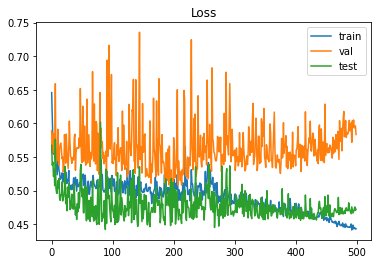

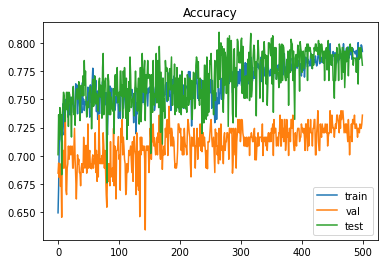

------------fold no---------1----------------------
Total samples in hospital A: 85
Total samples in hospital B: 81
Total samples in hospital C: 120
Total samples in hospital D: 95
Total samples in hospital E: 86
Total samples in hospital F: 550
Epoch 1: TrL=0.6350, TrA=0.6535, VL=0.5796, VA=0.6979, TeL=0.5597, TeA=0.7010, LR=0.00040,
Epoch 2: TrL=0.5925, TrA=0.7008, VL=0.6905, VA=0.6523, TeL=0.6452, TeA=0.6635, LR=0.00040,
Epoch 3: TrL=0.5850, TrA=0.7057, VL=0.6083, VA=0.7070, TeL=0.5685, TeA=0.7115, LR=0.00041,
Epoch 4: TrL=0.6016, TrA=0.7028, VL=0.6219, VA=0.6471, TeL=0.6020, TeA=0.6646, LR=0.00041,
Epoch 5: TrL=0.5959, TrA=0.6870, VL=0.5677, VA=0.7148, TeL=0.5349, TeA=0.7198, LR=0.00042,
Epoch 6: TrL=0.5633, TrA=0.7047, VL=0.5666, VA=0.7331, TeL=0.5239, TeA=0.7396, LR=0.00043,
Epoch 7: TrL=0.5615, TrA=0.7175, VL=0.5962, VA=0.7370, TeL=0.5370, TeA=0.7354, LR=0.00044,
Epoch 8: TrL=0.5519, TrA=0.7274, VL=0.5537, VA=0.7031, TeL=0.5213, TeA=0.7427, LR=0.00045,
Epoch 9: TrL=0.5485, TrA=0

Epoch 88: TrL=0.5033, TrA=0.7480, VL=0.5543, VA=0.7253, TeL=0.4583, TeA=0.7875, LR=0.00526,
Epoch 89: TrL=0.5074, TrA=0.7598, VL=0.5403, VA=0.7565, TeL=0.4793, TeA=0.7458, LR=0.00534,
Epoch 90: TrL=0.4933, TrA=0.7500, VL=0.5153, VA=0.7617, TeL=0.4724, TeA=0.7688, LR=0.00543,
Epoch 91: TrL=0.5039, TrA=0.7480, VL=0.5440, VA=0.7617, TeL=0.5112, TeA=0.7740, LR=0.00552,
Epoch 92: TrL=0.5000, TrA=0.7500, VL=0.5487, VA=0.7253, TeL=0.4610, TeA=0.7969, LR=0.00560,
Epoch 93: TrL=0.5021, TrA=0.7628, VL=0.5577, VA=0.7578, TeL=0.5272, TeA=0.7490, LR=0.00569,
Epoch 94: TrL=0.5341, TrA=0.7372, VL=0.5204, VA=0.7305, TeL=0.4688, TeA=0.7875, LR=0.00577,
Epoch 95: TrL=0.5010, TrA=0.7510, VL=0.5582, VA=0.7331, TeL=0.4734, TeA=0.7719, LR=0.00586,
Epoch 96: TrL=0.5196, TrA=0.7411, VL=0.5236, VA=0.7409, TeL=0.4779, TeA=0.7625, LR=0.00595,
Epoch 97: TrL=0.5027, TrA=0.7490, VL=0.5716, VA=0.7305, TeL=0.5022, TeA=0.7677, LR=0.00603,
Epoch 98: TrL=0.5074, TrA=0.7411, VL=0.5407, VA=0.7148, TeL=0.4714, TeA=0.7625, 

Epoch 177: TrL=0.4930, TrA=0.7618, VL=0.5376, VA=0.7617, TeL=0.4970, TeA=0.7552, LR=0.01000,
Epoch 178: TrL=0.5069, TrA=0.7490, VL=0.5262, VA=0.7305, TeL=0.4580, TeA=0.7781, LR=0.01000,
Epoch 179: TrL=0.5004, TrA=0.7608, VL=0.5212, VA=0.7344, TeL=0.4631, TeA=0.7906, LR=0.01000,
Epoch 180: TrL=0.4990, TrA=0.7746, VL=0.5365, VA=0.7474, TeL=0.4886, TeA=0.7906, LR=0.01000,
Epoch 181: TrL=0.4995, TrA=0.7648, VL=0.5233, VA=0.7383, TeL=0.4947, TeA=0.7771, LR=0.00999,
Epoch 182: TrL=0.4887, TrA=0.7667, VL=0.5152, VA=0.7383, TeL=0.4604, TeA=0.7615, LR=0.00999,
Epoch 183: TrL=0.4954, TrA=0.7579, VL=0.5644, VA=0.7695, TeL=0.5105, TeA=0.7458, LR=0.00999,
Epoch 184: TrL=0.4964, TrA=0.7628, VL=0.5351, VA=0.7487, TeL=0.4648, TeA=0.7750, LR=0.00999,
Epoch 185: TrL=0.5131, TrA=0.7549, VL=0.5449, VA=0.7109, TeL=0.4617, TeA=0.7719, LR=0.00998,
Epoch 186: TrL=0.5102, TrA=0.7618, VL=0.5325, VA=0.7578, TeL=0.4686, TeA=0.7844, LR=0.00998,
Epoch 187: TrL=0.5072, TrA=0.7608, VL=0.5461, VA=0.7435, TeL=0.4638, T

Epoch 266: TrL=0.4924, TrA=0.7648, VL=0.5318, VA=0.7487, TeL=0.4930, TeA=0.7750, LR=0.00882,
Epoch 267: TrL=0.4921, TrA=0.7559, VL=0.5446, VA=0.7383, TeL=0.4604, TeA=0.7844, LR=0.00879,
Epoch 268: TrL=0.4844, TrA=0.7687, VL=0.5695, VA=0.7227, TeL=0.4752, TeA=0.7594, LR=0.00877,
Epoch 269: TrL=0.4896, TrA=0.7589, VL=0.5208, VA=0.7487, TeL=0.4710, TeA=0.7844, LR=0.00874,
Epoch 270: TrL=0.4862, TrA=0.7579, VL=0.5276, VA=0.7422, TeL=0.4741, TeA=0.7781, LR=0.00871,
Epoch 271: TrL=0.5103, TrA=0.7559, VL=0.5394, VA=0.6992, TeL=0.4910, TeA=0.7594, LR=0.00869,
Epoch 272: TrL=0.5210, TrA=0.7402, VL=0.5363, VA=0.7422, TeL=0.4734, TeA=0.7781, LR=0.00866,
Epoch 273: TrL=0.4945, TrA=0.7638, VL=0.5178, VA=0.7409, TeL=0.4826, TeA=0.7844, LR=0.00864,
Epoch 274: TrL=0.5039, TrA=0.7520, VL=0.6550, VA=0.6875, TeL=0.5284, TeA=0.7438, LR=0.00861,
Epoch 275: TrL=0.4994, TrA=0.7569, VL=0.5409, VA=0.7266, TeL=0.4699, TeA=0.7781, LR=0.00858,
Epoch 276: TrL=0.4993, TrA=0.7667, VL=0.5312, VA=0.7227, TeL=0.4858, T

Epoch 355: TrL=0.4952, TrA=0.7687, VL=0.5586, VA=0.7266, TeL=0.4691, TeA=0.7812, LR=0.00591,
Epoch 356: TrL=0.4969, TrA=0.7589, VL=0.5517, VA=0.7227, TeL=0.4651, TeA=0.7802, LR=0.00587,
Epoch 357: TrL=0.4802, TrA=0.7687, VL=0.5600, VA=0.7266, TeL=0.4804, TeA=0.7646, LR=0.00584,
Epoch 358: TrL=0.5050, TrA=0.7579, VL=0.5618, VA=0.6992, TeL=0.4957, TeA=0.7844, LR=0.00580,
Epoch 359: TrL=0.5053, TrA=0.7490, VL=0.5545, VA=0.7526, TeL=0.4991, TeA=0.7594, LR=0.00576,
Epoch 360: TrL=0.5189, TrA=0.7441, VL=0.5481, VA=0.7096, TeL=0.4824, TeA=0.7750, LR=0.00572,
Epoch 361: TrL=0.5088, TrA=0.7500, VL=0.5302, VA=0.7214, TeL=0.4886, TeA=0.7781, LR=0.00568,
Epoch 362: TrL=0.5113, TrA=0.7559, VL=0.5145, VA=0.7096, TeL=0.4757, TeA=0.7781, LR=0.00565,
Epoch 363: TrL=0.4971, TrA=0.7638, VL=0.5748, VA=0.7188, TeL=0.5053, TeA=0.7615, LR=0.00561,
Epoch 364: TrL=0.4877, TrA=0.7667, VL=0.5575, VA=0.7227, TeL=0.4591, TeA=0.7906, LR=0.00557,
Epoch 365: TrL=0.4806, TrA=0.7746, VL=0.5532, VA=0.7148, TeL=0.4643, T

Epoch 444: TrL=0.4627, TrA=0.7657, VL=0.5729, VA=0.7266, TeL=0.4585, TeA=0.7875, LR=0.00260,
Epoch 445: TrL=0.4637, TrA=0.7815, VL=0.5528, VA=0.7201, TeL=0.4506, TeA=0.7781, LR=0.00256,
Epoch 446: TrL=0.4677, TrA=0.7766, VL=0.5498, VA=0.7227, TeL=0.4543, TeA=0.7844, LR=0.00253,
Epoch 447: TrL=0.4658, TrA=0.7766, VL=0.5450, VA=0.7279, TeL=0.4566, TeA=0.7844, LR=0.00250,
Epoch 448: TrL=0.4637, TrA=0.7805, VL=0.5591, VA=0.7344, TeL=0.4723, TeA=0.7750, LR=0.00246,
Epoch 449: TrL=0.4642, TrA=0.7776, VL=0.5477, VA=0.7109, TeL=0.4522, TeA=0.7781, LR=0.00243,
Epoch 450: TrL=0.4628, TrA=0.7785, VL=0.5596, VA=0.7188, TeL=0.4627, TeA=0.7906, LR=0.00240,
Epoch 451: TrL=0.4663, TrA=0.7805, VL=0.5651, VA=0.7161, TeL=0.4579, TeA=0.7750, LR=0.00236,
Epoch 452: TrL=0.4602, TrA=0.7825, VL=0.5582, VA=0.7266, TeL=0.4616, TeA=0.7719, LR=0.00233,
Epoch 453: TrL=0.4776, TrA=0.7736, VL=0.5581, VA=0.7383, TeL=0.4801, TeA=0.7646, LR=0.00230,
Epoch 454: TrL=0.4626, TrA=0.7785, VL=0.5634, VA=0.7240, TeL=0.4629, T

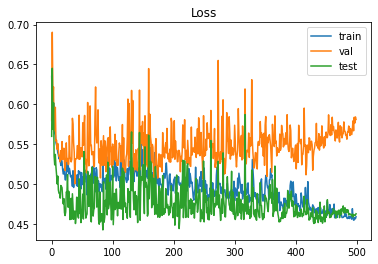

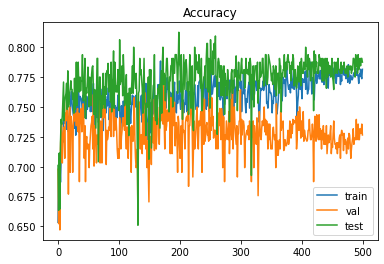

------------fold no---------2----------------------
Total samples in hospital A: 84
Total samples in hospital B: 79
Total samples in hospital C: 129
Total samples in hospital D: 99
Total samples in hospital E: 81
Total samples in hospital F: 545
Epoch 1: TrL=0.6488, TrA=0.6329, VL=0.6385, VA=0.7031, TeL=0.5780, TeA=0.7052, LR=0.00040,
Epoch 2: TrL=0.5810, TrA=0.7028, VL=0.6103, VA=0.7044, TeL=0.5658, TeA=0.7167, LR=0.00040,
Epoch 3: TrL=0.5827, TrA=0.6978, VL=0.6186, VA=0.7044, TeL=0.5467, TeA=0.7292, LR=0.00041,
Epoch 4: TrL=0.5661, TrA=0.7008, VL=0.6208, VA=0.7161, TeL=0.5455, TeA=0.7198, LR=0.00041,
Epoch 5: TrL=0.5558, TrA=0.7185, VL=0.5980, VA=0.7240, TeL=0.5312, TeA=0.7510, LR=0.00042,
Epoch 6: TrL=0.5569, TrA=0.7136, VL=0.5994, VA=0.7357, TeL=0.5225, TeA=0.7490, LR=0.00043,
Epoch 7: TrL=0.5489, TrA=0.7126, VL=0.6014, VA=0.7474, TeL=0.5189, TeA=0.7427, LR=0.00044,
Epoch 8: TrL=0.5493, TrA=0.7156, VL=0.5756, VA=0.7240, TeL=0.5150, TeA=0.7323, LR=0.00045,
Epoch 9: TrL=0.5496, TrA=0

Epoch 88: TrL=0.5293, TrA=0.7165, VL=0.5969, VA=0.7318, TeL=0.4939, TeA=0.7344, LR=0.00526,
Epoch 89: TrL=0.5251, TrA=0.7254, VL=0.5817, VA=0.7474, TeL=0.4727, TeA=0.7594, LR=0.00534,
Epoch 90: TrL=0.5150, TrA=0.7480, VL=0.5645, VA=0.7669, TeL=0.4754, TeA=0.7812, LR=0.00543,
Epoch 91: TrL=0.4965, TrA=0.7421, VL=0.6004, VA=0.7396, TeL=0.5060, TeA=0.7302, LR=0.00552,
Epoch 92: TrL=0.5065, TrA=0.7431, VL=0.6074, VA=0.7396, TeL=0.5329, TeA=0.7646, LR=0.00560,
Epoch 93: TrL=0.4931, TrA=0.7569, VL=0.6385, VA=0.7513, TeL=0.4775, TeA=0.7750, LR=0.00569,
Epoch 94: TrL=0.4920, TrA=0.7352, VL=0.6010, VA=0.7396, TeL=0.4833, TeA=0.7521, LR=0.00577,
Epoch 95: TrL=0.5076, TrA=0.7323, VL=0.6280, VA=0.7435, TeL=0.4933, TeA=0.7708, LR=0.00586,
Epoch 96: TrL=0.5279, TrA=0.7175, VL=0.6090, VA=0.7904, TeL=0.4764, TeA=0.7812, LR=0.00595,
Epoch 97: TrL=0.5006, TrA=0.7333, VL=0.6365, VA=0.7318, TeL=0.4668, TeA=0.7458, LR=0.00603,
Epoch 98: TrL=0.5115, TrA=0.7362, VL=0.6067, VA=0.7591, TeL=0.4852, TeA=0.7625, 

Epoch 177: TrL=0.4969, TrA=0.7549, VL=0.9517, VA=0.6771, TeL=0.5854, TeA=0.7323, LR=0.01000,
Epoch 178: TrL=0.5081, TrA=0.7451, VL=0.5536, VA=0.7552, TeL=0.4784, TeA=0.7812, LR=0.01000,
Epoch 179: TrL=0.5208, TrA=0.7392, VL=0.7079, VA=0.7357, TeL=0.5102, TeA=0.7625, LR=0.01000,
Epoch 180: TrL=0.4961, TrA=0.7539, VL=0.6781, VA=0.7513, TeL=0.4986, TeA=0.7646, LR=0.01000,
Epoch 181: TrL=0.4823, TrA=0.7569, VL=0.5951, VA=0.7591, TeL=0.4504, TeA=0.7562, LR=0.00999,
Epoch 182: TrL=0.4791, TrA=0.7530, VL=0.5882, VA=0.7630, TeL=0.4746, TeA=0.7969, LR=0.00999,
Epoch 183: TrL=0.4715, TrA=0.7520, VL=0.6470, VA=0.7266, TeL=0.4629, TeA=0.7562, LR=0.00999,
Epoch 184: TrL=0.4974, TrA=0.7480, VL=0.6810, VA=0.7513, TeL=0.4526, TeA=0.8063, LR=0.00999,
Epoch 185: TrL=0.5004, TrA=0.7530, VL=0.5558, VA=0.7669, TeL=0.4975, TeA=0.7875, LR=0.00998,
Epoch 186: TrL=0.5031, TrA=0.7569, VL=0.7546, VA=0.6250, TeL=0.5735, TeA=0.6792, LR=0.00998,
Epoch 187: TrL=0.4981, TrA=0.7520, VL=0.7826, VA=0.7513, TeL=0.4940, T

Epoch 266: TrL=0.4853, TrA=0.7559, VL=0.6024, VA=0.7435, TeL=0.4667, TeA=0.7719, LR=0.00882,
Epoch 267: TrL=0.4720, TrA=0.7559, VL=0.8493, VA=0.7786, TeL=0.4833, TeA=0.7812, LR=0.00879,
Epoch 268: TrL=0.4773, TrA=0.7598, VL=0.6655, VA=0.7786, TeL=0.4623, TeA=0.7906, LR=0.00877,
Epoch 269: TrL=0.4900, TrA=0.7657, VL=0.6936, VA=0.7591, TeL=0.4939, TeA=0.7844, LR=0.00874,
Epoch 270: TrL=0.4863, TrA=0.7520, VL=0.8136, VA=0.7357, TeL=0.4990, TeA=0.8021, LR=0.00871,
Epoch 271: TrL=0.4598, TrA=0.7756, VL=0.8255, VA=0.7279, TeL=0.4976, TeA=0.7688, LR=0.00869,
Epoch 272: TrL=0.4707, TrA=0.7618, VL=0.8491, VA=0.7161, TeL=0.5001, TeA=0.7552, LR=0.00866,
Epoch 273: TrL=0.4812, TrA=0.7470, VL=0.7536, VA=0.7122, TeL=0.5068, TeA=0.7594, LR=0.00864,
Epoch 274: TrL=0.4734, TrA=0.7638, VL=0.6114, VA=0.7826, TeL=0.4478, TeA=0.7844, LR=0.00861,
Epoch 275: TrL=0.4769, TrA=0.7598, VL=0.7275, VA=0.7786, TeL=0.4619, TeA=0.7969, LR=0.00858,
Epoch 276: TrL=0.4744, TrA=0.7648, VL=0.6872, VA=0.6992, TeL=0.5034, T

Epoch 355: TrL=0.4392, TrA=0.7815, VL=0.7539, VA=0.7396, TeL=0.4604, TeA=0.7906, LR=0.00591,
Epoch 356: TrL=0.4368, TrA=0.7795, VL=0.8681, VA=0.7279, TeL=0.4992, TeA=0.7906, LR=0.00587,
Epoch 357: TrL=0.4335, TrA=0.7943, VL=1.1167, VA=0.7161, TeL=0.5802, TeA=0.7750, LR=0.00584,
Epoch 358: TrL=0.4363, TrA=0.7844, VL=1.0034, VA=0.7513, TeL=0.5157, TeA=0.8063, LR=0.00580,
Epoch 359: TrL=0.4407, TrA=0.7844, VL=0.7744, VA=0.7591, TeL=0.4753, TeA=0.7812, LR=0.00576,
Epoch 360: TrL=0.4346, TrA=0.7766, VL=1.0358, VA=0.7279, TeL=0.5426, TeA=0.7844, LR=0.00572,
Epoch 361: TrL=0.4358, TrA=0.7884, VL=1.0049, VA=0.7708, TeL=0.4956, TeA=0.7937, LR=0.00568,
Epoch 362: TrL=0.4276, TrA=0.7835, VL=1.2711, VA=0.7513, TeL=0.5166, TeA=0.7969, LR=0.00565,
Epoch 363: TrL=0.4179, TrA=0.7904, VL=1.1632, VA=0.7708, TeL=0.4987, TeA=0.7969, LR=0.00561,
Epoch 364: TrL=0.4491, TrA=0.7756, VL=1.0627, VA=0.7279, TeL=0.5078, TeA=0.7656, LR=0.00557,
Epoch 365: TrL=0.4354, TrA=0.7795, VL=1.0288, VA=0.7161, TeL=0.5064, T

Epoch 444: TrL=0.4024, TrA=0.8012, VL=0.9891, VA=0.7708, TeL=0.5244, TeA=0.8094, LR=0.00260,
Epoch 445: TrL=0.4024, TrA=0.7982, VL=1.1979, VA=0.7318, TeL=0.5783, TeA=0.8063, LR=0.00256,
Epoch 446: TrL=0.3916, TrA=0.8031, VL=1.4166, VA=0.7630, TeL=0.5891, TeA=0.8063, LR=0.00253,
Epoch 447: TrL=0.3961, TrA=0.8041, VL=1.4735, VA=0.7591, TeL=0.6049, TeA=0.8125, LR=0.00250,
Epoch 448: TrL=0.4049, TrA=0.7953, VL=0.9310, VA=0.7747, TeL=0.4887, TeA=0.8000, LR=0.00246,
Epoch 449: TrL=0.4069, TrA=0.7913, VL=1.3151, VA=0.7630, TeL=0.5553, TeA=0.7969, LR=0.00243,
Epoch 450: TrL=0.3953, TrA=0.8041, VL=1.2513, VA=0.7552, TeL=0.5527, TeA=0.7969, LR=0.00240,
Epoch 451: TrL=0.3944, TrA=0.8051, VL=1.1888, VA=0.7552, TeL=0.5416, TeA=0.7844, LR=0.00236,
Epoch 452: TrL=0.3973, TrA=0.8012, VL=1.3041, VA=0.7552, TeL=0.5577, TeA=0.7906, LR=0.00233,
Epoch 453: TrL=0.4022, TrA=0.8061, VL=1.2492, VA=0.7396, TeL=0.5654, TeA=0.8031, LR=0.00230,
Epoch 454: TrL=0.3919, TrA=0.8041, VL=1.3544, VA=0.7591, TeL=0.5748, T

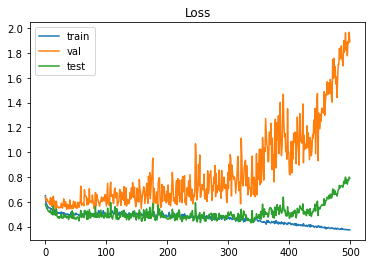

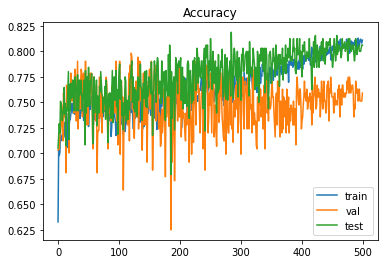

------------fold no---------3----------------------
Total samples in hospital A: 97
Total samples in hospital B: 76
Total samples in hospital C: 101
Total samples in hospital D: 108
Total samples in hospital E: 70
Total samples in hospital F: 565
Epoch 1: TrL=0.6483, TrA=0.6348, VL=0.5821, VA=0.7474, TeL=0.5755, TeA=0.7240, LR=0.00040,
Epoch 2: TrL=0.5957, TrA=0.6841, VL=0.5545, VA=0.7083, TeL=0.5625, TeA=0.7177, LR=0.00040,
Epoch 3: TrL=0.5815, TrA=0.7057, VL=0.5686, VA=0.7240, TeL=0.5480, TeA=0.7302, LR=0.00041,
Epoch 4: TrL=0.5971, TrA=0.6762, VL=0.5594, VA=0.7435, TeL=0.5424, TeA=0.7396, LR=0.00041,
Epoch 5: TrL=0.5880, TrA=0.7028, VL=0.6005, VA=0.6888, TeL=0.5639, TeA=0.6990, LR=0.00042,
Epoch 6: TrL=0.5795, TrA=0.7106, VL=0.5397, VA=0.7396, TeL=0.5357, TeA=0.7427, LR=0.00043,
Epoch 7: TrL=0.5640, TrA=0.7116, VL=0.5376, VA=0.7565, TeL=0.5156, TeA=0.7583, LR=0.00044,
Epoch 8: TrL=0.5567, TrA=0.7175, VL=0.5444, VA=0.7370, TeL=0.5087, TeA=0.7458, LR=0.00045,
Epoch 9: TrL=0.5530, TrA=

Epoch 88: TrL=0.5110, TrA=0.7530, VL=0.5238, VA=0.7669, TeL=0.4777, TeA=0.7448, LR=0.00526,
Epoch 89: TrL=0.5131, TrA=0.7500, VL=0.4910, VA=0.7799, TeL=0.4459, TeA=0.7833, LR=0.00534,
Epoch 90: TrL=0.4972, TrA=0.7579, VL=0.5227, VA=0.7318, TeL=0.4839, TeA=0.7844, LR=0.00543,
Epoch 91: TrL=0.5195, TrA=0.7402, VL=0.5078, VA=0.7552, TeL=0.4885, TeA=0.7542, LR=0.00552,
Epoch 92: TrL=0.5047, TrA=0.7539, VL=0.5086, VA=0.7604, TeL=0.4713, TeA=0.7740, LR=0.00560,
Epoch 93: TrL=0.5098, TrA=0.7500, VL=0.5215, VA=0.7760, TeL=0.4777, TeA=0.7708, LR=0.00569,
Epoch 94: TrL=0.4992, TrA=0.7480, VL=0.5442, VA=0.7409, TeL=0.4817, TeA=0.7583, LR=0.00577,
Epoch 95: TrL=0.5183, TrA=0.7274, VL=0.5794, VA=0.7331, TeL=0.4568, TeA=0.7656, LR=0.00586,
Epoch 96: TrL=0.5004, TrA=0.7598, VL=0.5391, VA=0.7526, TeL=0.4762, TeA=0.7771, LR=0.00595,
Epoch 97: TrL=0.5219, TrA=0.7490, VL=0.5473, VA=0.7669, TeL=0.5171, TeA=0.7573, LR=0.00603,
Epoch 98: TrL=0.5080, TrA=0.7451, VL=0.5319, VA=0.7526, TeL=0.4681, TeA=0.7771, 

Epoch 177: TrL=0.6936, TrA=0.4882, VL=0.6934, VA=0.4740, TeL=0.6929, TeA=0.5302, LR=0.01000,
Epoch 178: TrL=0.6937, TrA=0.4921, VL=0.6949, VA=0.4740, TeL=0.6919, TeA=0.5302, LR=0.01000,
Epoch 179: TrL=0.6935, TrA=0.4951, VL=0.6951, VA=0.4740, TeL=0.6918, TeA=0.5302, LR=0.01000,
Epoch 180: TrL=0.6938, TrA=0.5010, VL=0.6941, VA=0.4740, TeL=0.6923, TeA=0.5302, LR=0.01000,
Epoch 181: TrL=0.6937, TrA=0.5069, VL=0.6941, VA=0.4740, TeL=0.6923, TeA=0.5302, LR=0.00999,
Epoch 182: TrL=0.6937, TrA=0.5079, VL=0.6932, VA=0.4740, TeL=0.6931, TeA=0.5302, LR=0.00999,
Epoch 183: TrL=0.6939, TrA=0.5089, VL=0.6928, VA=0.5260, TeL=0.6936, TeA=0.4698, LR=0.00999,
Epoch 184: TrL=0.6938, TrA=0.4715, VL=0.6934, VA=0.4740, TeL=0.6929, TeA=0.5302, LR=0.00999,
Epoch 185: TrL=0.6935, TrA=0.4843, VL=0.6936, VA=0.4740, TeL=0.6927, TeA=0.5302, LR=0.00998,
Epoch 186: TrL=0.6936, TrA=0.4793, VL=0.6950, VA=0.4740, TeL=0.6918, TeA=0.5302, LR=0.00998,
Epoch 187: TrL=0.6934, TrA=0.5079, VL=0.6936, VA=0.4740, TeL=0.6927, T

Epoch 266: TrL=0.6936, TrA=0.4882, VL=0.6939, VA=0.4740, TeL=0.6925, TeA=0.5302, LR=0.00882,
Epoch 267: TrL=0.6932, TrA=0.5089, VL=0.6930, VA=0.5260, TeL=0.6933, TeA=0.4698, LR=0.00879,
Epoch 268: TrL=0.6938, TrA=0.4734, VL=0.6937, VA=0.4740, TeL=0.6926, TeA=0.5302, LR=0.00877,
Epoch 269: TrL=0.6932, TrA=0.5020, VL=0.6947, VA=0.4740, TeL=0.6920, TeA=0.5302, LR=0.00874,
Epoch 270: TrL=0.6936, TrA=0.5069, VL=0.6934, VA=0.4740, TeL=0.6929, TeA=0.5302, LR=0.00871,
Epoch 271: TrL=0.6933, TrA=0.4990, VL=0.6953, VA=0.4740, TeL=0.6917, TeA=0.5302, LR=0.00869,
Epoch 272: TrL=0.6943, TrA=0.5069, VL=0.6942, VA=0.4740, TeL=0.6923, TeA=0.5302, LR=0.00866,
Epoch 273: TrL=0.6935, TrA=0.5069, VL=0.6941, VA=0.4740, TeL=0.6923, TeA=0.5302, LR=0.00864,
Epoch 274: TrL=0.6934, TrA=0.5000, VL=0.6941, VA=0.4740, TeL=0.6923, TeA=0.5302, LR=0.00861,
Epoch 275: TrL=0.6935, TrA=0.5079, VL=0.6933, VA=0.4740, TeL=0.6930, TeA=0.5302, LR=0.00858,
Epoch 276: TrL=0.6935, TrA=0.4862, VL=0.6945, VA=0.4740, TeL=0.6921, T

Epoch 355: TrL=0.6934, TrA=0.5069, VL=0.6941, VA=0.4740, TeL=0.6923, TeA=0.5302, LR=0.00591,
Epoch 356: TrL=0.6934, TrA=0.4931, VL=0.6941, VA=0.4740, TeL=0.6923, TeA=0.5302, LR=0.00587,
Epoch 357: TrL=0.6936, TrA=0.5069, VL=0.6942, VA=0.4740, TeL=0.6923, TeA=0.5302, LR=0.00584,
Epoch 358: TrL=0.6936, TrA=0.5069, VL=0.6939, VA=0.4740, TeL=0.6925, TeA=0.5302, LR=0.00580,
Epoch 359: TrL=0.6936, TrA=0.4734, VL=0.6947, VA=0.4740, TeL=0.6920, TeA=0.5302, LR=0.00576,
Epoch 360: TrL=0.6933, TrA=0.5079, VL=0.6947, VA=0.4740, TeL=0.6920, TeA=0.5302, LR=0.00572,
Epoch 361: TrL=0.6935, TrA=0.5079, VL=0.6943, VA=0.4740, TeL=0.6922, TeA=0.5302, LR=0.00568,
Epoch 362: TrL=0.6934, TrA=0.5069, VL=0.6938, VA=0.4740, TeL=0.6926, TeA=0.5302, LR=0.00565,
Epoch 363: TrL=0.6935, TrA=0.5079, VL=0.6942, VA=0.4740, TeL=0.6922, TeA=0.5302, LR=0.00561,
Epoch 364: TrL=0.6935, TrA=0.5079, VL=0.6944, VA=0.4740, TeL=0.6922, TeA=0.5302, LR=0.00557,
Epoch 365: TrL=0.6933, TrA=0.5069, VL=0.6945, VA=0.4740, TeL=0.6921, T

Epoch 444: TrL=0.6931, TrA=0.5079, VL=0.6942, VA=0.4740, TeL=0.6922, TeA=0.5302, LR=0.00260,
Epoch 445: TrL=0.6932, TrA=0.5079, VL=0.6942, VA=0.4740, TeL=0.6922, TeA=0.5302, LR=0.00256,
Epoch 446: TrL=0.6933, TrA=0.5069, VL=0.6939, VA=0.4740, TeL=0.6924, TeA=0.5302, LR=0.00253,
Epoch 447: TrL=0.6934, TrA=0.5069, VL=0.6942, VA=0.4740, TeL=0.6922, TeA=0.5302, LR=0.00250,
Epoch 448: TrL=0.6931, TrA=0.5079, VL=0.6942, VA=0.4740, TeL=0.6922, TeA=0.5302, LR=0.00246,
Epoch 449: TrL=0.6932, TrA=0.5069, VL=0.6940, VA=0.4740, TeL=0.6924, TeA=0.5302, LR=0.00243,
Epoch 450: TrL=0.6933, TrA=0.5079, VL=0.6942, VA=0.4740, TeL=0.6923, TeA=0.5302, LR=0.00240,
Epoch 451: TrL=0.6933, TrA=0.5069, VL=0.6941, VA=0.4740, TeL=0.6923, TeA=0.5302, LR=0.00236,
Epoch 452: TrL=0.6933, TrA=0.5079, VL=0.6946, VA=0.4740, TeL=0.6920, TeA=0.5302, LR=0.00233,
Epoch 453: TrL=0.6932, TrA=0.5069, VL=0.6940, VA=0.4740, TeL=0.6924, TeA=0.5302, LR=0.00230,
Epoch 454: TrL=0.6931, TrA=0.5069, VL=0.6940, VA=0.4740, TeL=0.6924, T

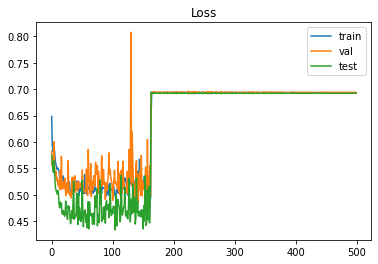

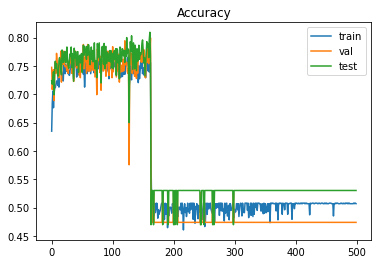

------------fold no---------4----------------------
Total samples in hospital A: 115
Total samples in hospital B: 104
Total samples in hospital C: 134
Total samples in hospital D: 139
Total samples in hospital E: 101
Total samples in hospital F: 424
Epoch 1: TrL=0.6557, TrA=0.6073, VL=0.6343, VA=0.6406, TeL=0.5925, TeA=0.7042, LR=0.00040,
Epoch 2: TrL=0.5838, TrA=0.6939, VL=0.6089, VA=0.6523, TeL=0.5515, TeA=0.7354, LR=0.00040,
Epoch 3: TrL=0.5704, TrA=0.7185, VL=0.6008, VA=0.6771, TeL=0.5446, TeA=0.7292, LR=0.00041,
Epoch 4: TrL=0.5736, TrA=0.7156, VL=0.5914, VA=0.6680, TeL=0.5421, TeA=0.7458, LR=0.00041,
Epoch 5: TrL=0.5547, TrA=0.7185, VL=0.5961, VA=0.6719, TeL=0.5338, TeA=0.7490, LR=0.00042,
Epoch 6: TrL=0.5537, TrA=0.7215, VL=0.5850, VA=0.6888, TeL=0.5168, TeA=0.7490, LR=0.00043,
Epoch 7: TrL=0.5487, TrA=0.7323, VL=0.5841, VA=0.6823, TeL=0.5230, TeA=0.7240, LR=0.00044,
Epoch 8: TrL=0.5337, TrA=0.7283, VL=0.5730, VA=0.6927, TeL=0.5029, TeA=0.7490, LR=0.00045,
Epoch 9: TrL=0.5293, T

Epoch 88: TrL=0.5055, TrA=0.7589, VL=0.5555, VA=0.6940, TeL=0.4730, TeA=0.7562, LR=0.00526,
Epoch 89: TrL=0.5064, TrA=0.7608, VL=0.5556, VA=0.6758, TeL=0.4578, TeA=0.7688, LR=0.00534,
Epoch 90: TrL=0.5092, TrA=0.7687, VL=0.5441, VA=0.7253, TeL=0.4777, TeA=0.7719, LR=0.00543,
Epoch 91: TrL=0.5153, TrA=0.7549, VL=0.6179, VA=0.6654, TeL=0.5118, TeA=0.7323, LR=0.00552,
Epoch 92: TrL=0.4965, TrA=0.7657, VL=0.5997, VA=0.6862, TeL=0.4884, TeA=0.7583, LR=0.00560,
Epoch 93: TrL=0.4962, TrA=0.7677, VL=0.6100, VA=0.5951, TeL=0.5447, TeA=0.6885, LR=0.00569,
Epoch 94: TrL=0.5054, TrA=0.7510, VL=0.5945, VA=0.6602, TeL=0.5031, TeA=0.7490, LR=0.00577,
Epoch 95: TrL=0.4810, TrA=0.7707, VL=0.5565, VA=0.6836, TeL=0.4699, TeA=0.7667, LR=0.00586,
Epoch 96: TrL=0.4841, TrA=0.7657, VL=0.7021, VA=0.6602, TeL=0.5513, TeA=0.7688, LR=0.00595,
Epoch 97: TrL=0.5076, TrA=0.7638, VL=0.5711, VA=0.6628, TeL=0.5063, TeA=0.7427, LR=0.00603,
Epoch 98: TrL=0.4989, TrA=0.7461, VL=0.6335, VA=0.6562, TeL=0.5139, TeA=0.7594, 

Epoch 177: TrL=0.4762, TrA=0.7736, VL=0.5602, VA=0.7174, TeL=0.4758, TeA=0.7937, LR=0.01000,
Epoch 178: TrL=0.5065, TrA=0.7618, VL=0.5458, VA=0.7174, TeL=0.5001, TeA=0.7719, LR=0.01000,
Epoch 179: TrL=0.4885, TrA=0.7746, VL=0.5364, VA=0.7214, TeL=0.4755, TeA=0.7562, LR=0.01000,
Epoch 180: TrL=0.5080, TrA=0.7648, VL=0.5528, VA=0.7031, TeL=0.4897, TeA=0.7615, LR=0.01000,
Epoch 181: TrL=0.4896, TrA=0.7510, VL=0.5813, VA=0.6719, TeL=0.4820, TeA=0.7708, LR=0.00999,
Epoch 182: TrL=0.5023, TrA=0.7569, VL=0.5441, VA=0.6979, TeL=0.4497, TeA=0.7688, LR=0.00999,
Epoch 183: TrL=0.4810, TrA=0.7667, VL=0.5864, VA=0.6680, TeL=0.4934, TeA=0.7542, LR=0.00999,
Epoch 184: TrL=0.4792, TrA=0.7667, VL=0.5507, VA=0.7135, TeL=0.4694, TeA=0.7771, LR=0.00999,
Epoch 185: TrL=0.4982, TrA=0.7451, VL=0.5826, VA=0.6862, TeL=0.4901, TeA=0.7625, LR=0.00998,
Epoch 186: TrL=0.4926, TrA=0.7648, VL=0.5460, VA=0.6875, TeL=0.4657, TeA=0.7719, LR=0.00998,
Epoch 187: TrL=0.4983, TrA=0.7717, VL=0.5488, VA=0.7057, TeL=0.4611, T

Epoch 266: TrL=0.4728, TrA=0.7707, VL=0.5563, VA=0.7174, TeL=0.4476, TeA=0.7719, LR=0.00882,
Epoch 267: TrL=0.4804, TrA=0.7638, VL=0.5858, VA=0.6784, TeL=0.5040, TeA=0.7677, LR=0.00879,
Epoch 268: TrL=0.4656, TrA=0.7726, VL=0.6150, VA=0.6667, TeL=0.4989, TeA=0.7552, LR=0.00877,
Epoch 269: TrL=0.4741, TrA=0.7598, VL=0.6218, VA=0.6797, TeL=0.5093, TeA=0.7688, LR=0.00874,
Epoch 270: TrL=0.4692, TrA=0.7795, VL=0.5412, VA=0.7214, TeL=0.4546, TeA=0.7719, LR=0.00871,
Epoch 271: TrL=0.4675, TrA=0.7854, VL=0.5579, VA=0.6836, TeL=0.4692, TeA=0.7688, LR=0.00869,
Epoch 272: TrL=0.5004, TrA=0.7618, VL=0.5923, VA=0.6549, TeL=0.4604, TeA=0.7531, LR=0.00866,
Epoch 273: TrL=0.4824, TrA=0.7697, VL=0.5805, VA=0.6979, TeL=0.4522, TeA=0.7594, LR=0.00864,
Epoch 274: TrL=0.4822, TrA=0.7667, VL=0.6014, VA=0.6628, TeL=0.4948, TeA=0.7740, LR=0.00861,
Epoch 275: TrL=0.4817, TrA=0.7549, VL=0.5618, VA=0.6940, TeL=0.4558, TeA=0.7656, LR=0.00858,
Epoch 276: TrL=0.4844, TrA=0.7736, VL=0.5561, VA=0.6745, TeL=0.4497, T

Epoch 355: TrL=0.4555, TrA=0.7717, VL=0.5728, VA=0.6641, TeL=0.4615, TeA=0.7500, LR=0.00591,
Epoch 356: TrL=0.4504, TrA=0.7687, VL=0.6106, VA=0.6471, TeL=0.4920, TeA=0.7365, LR=0.00587,
Epoch 357: TrL=0.4500, TrA=0.7756, VL=0.6386, VA=0.6745, TeL=0.4691, TeA=0.7688, LR=0.00584,
Epoch 358: TrL=0.4710, TrA=0.7470, VL=0.5523, VA=0.6549, TeL=0.4796, TeA=0.7458, LR=0.00580,
Epoch 359: TrL=0.4600, TrA=0.7618, VL=0.5474, VA=0.6654, TeL=0.4589, TeA=0.7781, LR=0.00576,
Epoch 360: TrL=0.4452, TrA=0.7736, VL=0.5893, VA=0.6641, TeL=0.4669, TeA=0.7688, LR=0.00572,
Epoch 361: TrL=0.4497, TrA=0.7785, VL=0.5680, VA=0.6706, TeL=0.4564, TeA=0.7656, LR=0.00568,
Epoch 362: TrL=0.4435, TrA=0.7726, VL=0.5993, VA=0.6732, TeL=0.4723, TeA=0.7656, LR=0.00565,
Epoch 363: TrL=0.4385, TrA=0.7854, VL=0.6027, VA=0.6458, TeL=0.4597, TeA=0.7750, LR=0.00561,
Epoch 364: TrL=0.4723, TrA=0.7697, VL=0.5626, VA=0.6862, TeL=0.4894, TeA=0.7844, LR=0.00557,
Epoch 365: TrL=0.4505, TrA=0.7805, VL=0.5936, VA=0.6706, TeL=0.4834, T

Epoch 444: TrL=0.4288, TrA=0.7894, VL=0.6586, VA=0.6523, TeL=0.5066, TeA=0.7688, LR=0.00260,
Epoch 445: TrL=0.4287, TrA=0.7904, VL=0.6269, VA=0.6693, TeL=0.4883, TeA=0.7750, LR=0.00256,
Epoch 446: TrL=0.4257, TrA=0.7923, VL=0.6055, VA=0.6654, TeL=0.4834, TeA=0.7719, LR=0.00253,
Epoch 447: TrL=0.4225, TrA=0.7884, VL=0.6664, VA=0.6849, TeL=0.4919, TeA=0.7656, LR=0.00250,
Epoch 448: TrL=0.4233, TrA=0.7894, VL=0.6647, VA=0.7057, TeL=0.4934, TeA=0.7719, LR=0.00246,
Epoch 449: TrL=0.4284, TrA=0.7815, VL=0.6280, VA=0.7057, TeL=0.4797, TeA=0.7812, LR=0.00243,
Epoch 450: TrL=0.4240, TrA=0.7884, VL=0.6305, VA=0.6562, TeL=0.4964, TeA=0.7719, LR=0.00240,
Epoch 451: TrL=0.4245, TrA=0.7953, VL=0.6027, VA=0.7057, TeL=0.4775, TeA=0.7719, LR=0.00236,
Epoch 452: TrL=0.4225, TrA=0.7835, VL=0.6180, VA=0.6940, TeL=0.4761, TeA=0.7750, LR=0.00233,
Epoch 453: TrL=0.4229, TrA=0.7913, VL=0.6900, VA=0.6589, TeL=0.5082, TeA=0.7625, LR=0.00230,
Epoch 454: TrL=0.4271, TrA=0.7874, VL=0.6107, VA=0.6536, TeL=0.4871, T

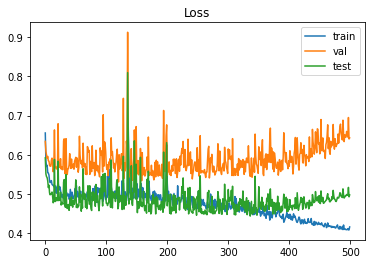

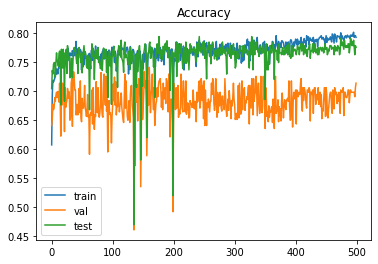

In [157]:
skf = StratifiedKFold(n_splits=5)
epochs=500
for fold,(train_idx, val_idx) in enumerate(skf.split(train_val, tv_labels)):
    writer = SummaryWriter("runs/STRATIFIED TEXT-ONLY", filename_suffix=f"_F{fold}_E{epochs}_")
    print('------------fold no---------{}----------------------'.format(fold))   
    train_df = df.iloc[train_idx]
    train_set = TextDataset(indices=train_df, image_dir=f"{data_path}DATASET", transform=my_transform)

    val_df = df.iloc[val_idx]
    val_set = TextDataset(indices=val_df, image_dir=f"{data_path}DATASET", transform=my_transform)
    
    print("Total samples in hospital A:",len(df.iloc[train_idx][df.iloc[train_idx]["Hospital"]==1]))
    print("Total samples in hospital B:",len(df.iloc[train_idx][df.iloc[train_idx]["Hospital"]==2]))
    print("Total samples in hospital C:",len(df.iloc[train_idx][df.iloc[train_idx]["Hospital"]==3]))
    print("Total samples in hospital D:",len(df.iloc[train_idx][df.iloc[train_idx]["Hospital"]==4]))
    print("Total samples in hospital E:",len(df.iloc[train_idx][df.iloc[train_idx]["Hospital"]==5]))
    print("Total samples in hospital F:",len(df.iloc[train_idx][df.iloc[train_idx]["Hospital"]==6]))
    
    train_loader = DataLoader(train_set, batch_size=8, num_workers=2, drop_last=True, shuffle=True, generator=generator)
    val_loader   = DataLoader(val_set,   batch_size=8, num_workers=2, drop_last=False, shuffle=False, generator=generator)
    
    # Define dictionary of loaders
    loaders = {"train": train_loader,
               "val": val_loader,
               "test": test_loader}

    # Define an optimizier
    import torch.optim as optim
    optimizer = optim.Adam(model.parameters(), lr = 0.0001)
    # Define a loss 
    criterion = nn.BCEWithLogitsLoss()
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr = 0.01, epochs=5, steps_per_epoch=350)
    
    
    #model, optimizer = ipex.optimize(model, optimizer=optimizer,dtype=torch.double)
    #model = model.float()
    # Train model
    train(model, loaders, optimizer, criterion, epochs=500, dev=dev)
    writer.flush()
    writer.close()
    model.apply(reset_weights)